# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm import tqdm
from typing import Optional, List, Union # type tips

# Load Data

In [2]:
# df is the non-normalized passive data with features and target 
df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_passive_fe.csv')

# mlm_gap_df is the results of the MLM on the gap data
mlm_gap_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
mlm_affect_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_affect_results_df.csv')

## Train-Test Split

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

In [3]:
# Get last day of data collection for each PID based on unlock duration data
last_days = df.groupby('PID').agg({
    'day': lambda x: x[df['passive_sk_device_total_unlock_duration'].notna()].max()
}).reset_index()

# Remove any data after each PID's last day
tt_filtered = pd.merge(
    df,
    last_days,
    on='PID',
    suffixes=('', '_last')
)
tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]

# Create train/test splits for each PID
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for pid in tt_filtered['PID'].unique():
    pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
    
    # Sort by day to ensure chronological split
    pid_data = pid_data.sort_values('day')
    
    # Calculate split point at 80%
    split_idx = int(len(pid_data) * 0.8)
    
    # Split the data
    train_pid = pid_data.iloc[:split_idx]
    test_pid = pid_data.iloc[split_idx:]
    
    # Append to main dataframes
    train_data = pd.concat([train_data, train_pid])
    test_data = pd.concat([test_data, test_pid])

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of unique PIDs in training: {train_data['PID'].nunique()}")
print(f"Number of unique PIDs in test: {test_data['PID'].nunique()}")

Training set size: 5141
Test set size: 1350
Number of unique PIDs in training: 105
Number of unique PIDs in test: 105


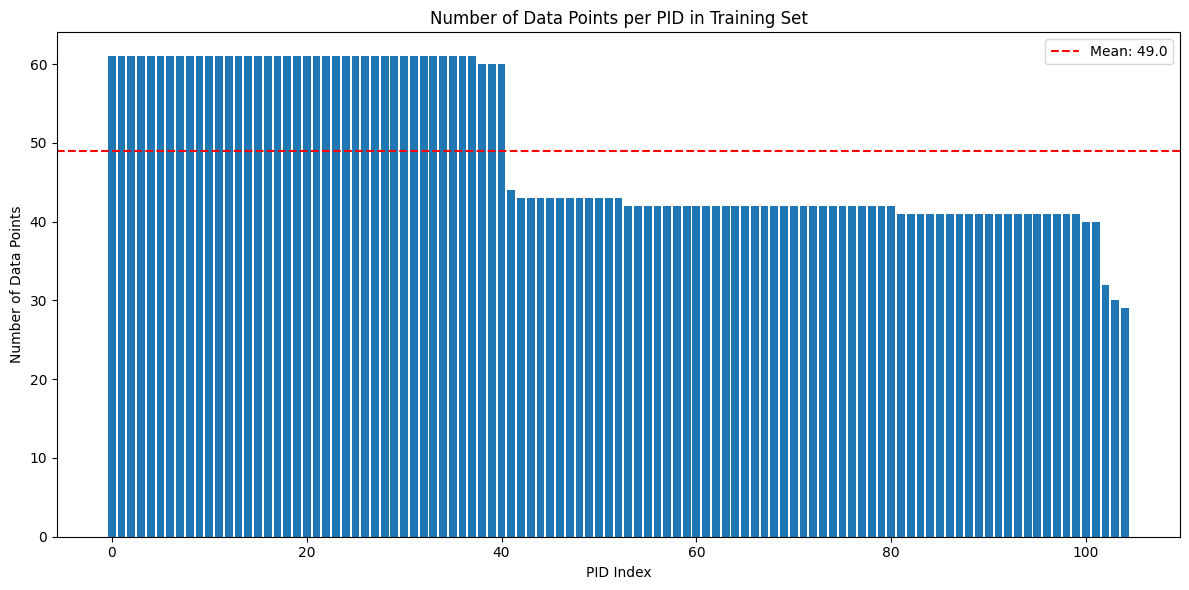

In [4]:
# Count data points per PID in training set
pid_counts = train_data['PID'].value_counts()

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pid_counts)), pid_counts.values)
plt.xlabel('PID Index')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per PID in Training Set')

# Add mean line
mean_points = pid_counts.mean()
plt.axhline(y=mean_points, color='r', linestyle='--', label=f'Mean: {mean_points:.1f}')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [5]:
# Check for empty, binary (0/1) columns and non-numeric columns
empty_cols = []
binary_cols = []
non_numeric_cols = []

for col in train_data.columns:
    # Check if column is empty (all NaN)
    if train_data[col].isna().all():
        empty_cols.append(col)
        continue
        
    # Check if column is non-numeric
    if not np.issubdtype(train_data[col].dtype, np.number):
        non_numeric_cols.append(col)
        continue
        
    # Check if column only contains 0s and 1s
    unique_vals = train_data[col].unique()
    unique_vals = unique_vals[~np.isnan(unique_vals)]  # Remove NaN values
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

print("Empty columns:")
print(empty_cols)
print("\nBinary columns:")
print(binary_cols)
print("\nNon-numeric columns:")
print(non_numeric_cols)


Empty columns:
[]

Binary columns:
['survey_complete', 'tasks_complete', 'watch_wearing', 'weekend', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'fe_lag_1_survey_complete', 'fe_lag_2_survey_complete', 'fe_lag_3_survey_complete', 'fe_lag_1_tasks_complete', 'fe_lag_2_tasks_complete', 'fe_lag_3_tasks_complete', 'fe_lag_1_watch_wearing', 'fe_lag_2_watch_wearing', 'fe_lag_3_watch_wearing']

Non-numeric columns:
['PID', 'trial_date', 'cohort']


# Functions

In [20]:
def expanding_window_cv_nested(df: pd.DataFrame, validation_days: int = 15) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Performs expanding window cross-validation accounting for nested observations within subjects.
    Creates 5 splits, each moving forward by 3 days and using 3 days for validation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Training data containing 'PID' and 'day' columns
    validation_days : int
        Number of days to use for validation windows
        
    Returns:
    --------
    list of tuples
        Each tuple contains (train_idx, val_idx) for one fold, 
        where indices from all subjects are combined
    """
    # Dictionary to store splits by window position
    window_splits = {}  # {window_position: [(train_idx, val_idx), ...]}
    
    # Process each subject separately
    for pid in df['PID'].unique():
        # Get data for this subject
        subject_data = df[df['PID'] == pid].copy()
        
        # Get sorted unique days for this subject
        subject_days = sorted(subject_data['day'].unique())
        n_days = len(subject_days)
        
        # Skip subjects with too few observations
        if n_days < 25:  # means min of 10 days in initial training
            continue
            
        # Determine window days for this subject
        window_start_idx = max(0, n_days - validation_days)
        window_days = subject_days[window_start_idx:]
        
        # Create 5 splits, moving forward by 3 days each time
        for window_pos in range(0, 5):  # 5 splits
            val_start_idx = window_start_idx + (window_pos * 3)  # Move forward by 3 days each time
            
            # Skip if we don't have enough days left
            if val_start_idx + 3 > len(subject_days):
                continue
                
            # Get 3 validation days
            val_days = subject_days[val_start_idx:val_start_idx + 3]
            
            # Get training days (all days up to validation period)
            train_days = subject_days[:val_start_idx]
            
            # Get indices for this split
            train_mask = (df['PID'] == pid) & (df['day'].isin(train_days))
            val_mask = (df['PID'] == pid) & (df['day'].isin(val_days))
            
            # Convert to indices
            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]
            
            # Only add split if we have both training and validation data
            if len(train_idx) > 0 and len(val_idx) > 0:
                # Add to window_splits dictionary
                if window_pos not in window_splits:
                    window_splits[window_pos] = []
                window_splits[window_pos].append((train_idx, val_idx))
    
    # Combine splits for each window position
    combined_splits = []
    for window_pos in sorted(window_splits.keys()):
        # Combine all train indices and all val indices for this window position
        all_train_idx = np.concatenate([split[0] for split in window_splits[window_pos]])
        all_val_idx = np.concatenate([split[1] for split in window_splits[window_pos]])
        combined_splits.append((all_train_idx, all_val_idx))
    
    return combined_splits

# Model Pipeline

In [31]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
#warnings.filterwarnings('ignore')

## Functions

### Feature Engineering and Scaling Functions

In [33]:
def prepare_data(df, features, target_col='target'):
    # X and y extraction
    X = df[features].values
    y = df[target_col].values
    return X, y

def fit_scaler(train_df, features):
    scaler = StandardScaler()
    scaler.fit(train_df[features])
    return scaler

def transform_data(df, scaler, features):
    X = scaler.transform(df[features])
    return X


### Categorical Threshold Functions

In [34]:
def compute_subject_thresholds(train_data, target_col='target'):
    """
    Compute per-subject thresholds for median and terciles.
    Returns dicts keyed by PID:
      median_thresholds[PID] = median_value
      tercile_thresholds[PID] = (lower_tercile_value, upper_tercile_value)
    """
    median_thresholds = {}
    tercile_thresholds = {}
    for pid, pid_df in train_data.groupby('PID'):
        vals = pid_df[target_col].values
        median_val = np.median(vals)
        # Terciles
        lower_tercile = np.percentile(vals, 66.66) # top tercile starts above this
        tercile_thresholds[pid] = lower_tercile
        median_thresholds[pid] = median_val
    return median_thresholds, tercile_thresholds

def apply_median_split(x, median_val):
    return 1 if x > median_val else 0

def apply_tercile_split(x, tercile_val):
    # top tercile is > tercile_val
    return 1 if x > tercile_val else 0

def create_categorical_labels(df, median_thresh, tercile_thresh, target_col='target'):
    # 1. Median split label
    df['median_label'] = df.apply(lambda row: apply_median_split(row[target_col], median_thresh[row['PID']]), axis=1)
    # 2. Tercile split label
    df['tercile_label'] = df.apply(lambda row: apply_tercile_split(row[target_col], tercile_thresh[row['PID']]), axis=1)
    return df

def create_change_labels(df, target_col='target', median_thresh=None, tercile_thresh=None):
    # For each PID, sort by day and create various labels
    def pid_change_labels(pid_df):
        pid_df = pid_df.sort_values('day')
        vals = pid_df[target_col].values
        
        # median low-high change
        if median_thresh is not None:
            med = median_thresh[pid_df['PID'].iloc[0]]
            low_high = (vals > med).astype(int)
            # low to high change: current=1, previous=0
            pid_df['median_low_high_change'] = np.insert((low_high[1:] == 1) & (low_high[:-1] == 0), 0, False).astype(int)
        else:
            pid_df['median_low_high_change'] = np.nan
        
        # tercile low-high change
        if tercile_thresh is not None:
            t_val = tercile_thresh[pid_df['PID'].iloc[0]]
            low_high_terc = (vals > t_val).astype(int)
            pid_df['tercile_low_high_change'] = np.insert((low_high_terc[1:] == 1) & (low_high_terc[:-1] == 0), 0, False).astype(int)
        else:
            pid_df['tercile_low_high_change'] = np.nan
        
        # daily change direction
        diff = np.insert(np.diff(vals), 0, 0)
        pid_df['daily_change_direction'] = (diff > 0).astype(int)
        
        # large increase (>=1 SD)
        std_val = np.std(vals)
        large_inc = np.insert((np.diff(vals) >= std_val), 0, False).astype(int)
        pid_df['large_increase'] = large_inc
        
        return pid_df
    
    df = df.groupby('PID', group_keys=False).apply(pid_change_labels)
    return df


### Evaluation Functions

In [32]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

def classification_metrics(y_true, y_pred):
    # y_pred are class labels
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec, f1

### Standard ML Model Functions

In [ ]:
def train_regression_model(X_train, y_train, model_type='linear'):
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'gbm':
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    elif model_type == 'xgb':
        model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    elif model_type == 'lgb':
        model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError("Unknown model type")
    model.fit(X_train, y_train)
    return model

def train_classification_model(X_train, y_train, model_type='logistic'):
    if model_type == 'logistic':
        model = LogisticRegression()
    elif model_type == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'gbm':
        model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    elif model_type == 'xgb':
        model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    elif model_type == 'lgb':
        model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
    else:
        raise ValueError("Unknown model type")
    model.fit(X_train, y_train)
    return model

### Deep Learning Model Functions

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=7):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.X) - self.seq_len
    
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def train_lstm_model(X_train, y_train, input_size, seq_len=7, epochs=10):
    dataset = TimeSeriesDataset(X_train, y_train, seq_len=seq_len)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = LSTMModel(input_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        for Xb, yb in loader:
            Xb = Xb.float()
            yb = yb.float().unsqueeze(1)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
    return model

# For a transformer or classification with neural nets, you’d define a similar class and training routine

### Prediction and Evaluation at Group-Level, Individual-Level, and Combined

In [ ]:
def make_predictions(model, X):
    if hasattr(model, 'predict'):
        return model.predict(X)
    else:
        # For PyTorch models
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            return model(X_t).numpy().ravel()

### Main Pipeline

In [ ]:
def main_pipeline(train_data_clean, test_data_clean, features, target_col='target'):
    # Compute thresholds from training data for categorical splits
    median_thresh, tercile_thresh = compute_subject_thresholds(train_data_clean, target_col=target_col)
    
    # Create all categorical labels for training and test data
    train_data_clean = create_categorical_labels(train_data_clean, median_thresh, tercile_thresh, target_col=target_col)
    train_data_clean = create_change_labels(train_data_clean, target_col=target_col, 
                                             median_thresh=median_thresh, tercile_thresh=tercile_thresh)
    
    test_data_clean = create_categorical_labels(test_data_clean, median_thresh, tercile_thresh, target_col=target_col)
    test_data_clean = create_change_labels(test_data_clean, target_col=target_col, 
                                           median_thresh=median_thresh, tercile_thresh=tercile_thresh)
    
    # Determine folds for cross-validation
    # Assuming we have them predefined or using create_global_folds
    # folds_structure = create_global_folds(train_data_clean)
    # For simplicity, assume folds are precomputed or we just show a single fold:
    # In reality, you'd loop over folds for CV and store results.
    
    # Group-level model (Regression)
    scaler = fit_scaler(train_data_clean, features)
    X_train_full, y_train_full = prepare_data(train_data_clean, features, target_col=target_col)
    X_train_full = transform_data(train_data_clean, scaler, features)
    
    # Example: Train a linear regression as group-level model
    group_model = train_regression_model(X_train_full, y_train_full, model_type='linear')
    
    # Individual-level models (Regression)
    individual_models = {}
    for pid, pid_df in train_data_clean.groupby('PID'):
        Xp, yp = prepare_data(pid_df, features, target_col=target_col)
        Xp = scaler.transform(pid_df[features])
        if len(Xp) > 10:  # Need some minimal data
            individual_models[pid] = train_regression_model(Xp, yp, model_type='rf')
        else:
            # fallback to group model
            individual_models[pid] = group_model

    # Combined predictions: For test_data
    X_test = transform_data(test_data_clean, scaler, features)
    y_test = test_data_clean[target_col].values
    p_group = group_model.predict(X_test)
    
    p_individual = np.zeros_like(y_test)
    for i, row in test_data_clean.iterrows():
        pid = row['PID']
        x_row = X_test[i:i+1]
        p_individual[i] = individual_models[pid].predict(x_row)
    
    p_combined = 0.5 * p_group + 0.5 * p_individual  # Simple average
    
    # Evaluate regression metrics on test set
    group_mae, group_rmse = regression_metrics(y_test, p_group)
    ind_mae, ind_rmse = regression_metrics(y_test, p_individual)
    comb_mae, comb_rmse = regression_metrics(y_test, p_combined)
    
    print("Group-level model: MAE=%.3f, RMSE=%.3f" % (group_mae, group_rmse))
    print("Individual-level model: MAE=%.3f, RMSE=%.3f" % (ind_mae, ind_rmse))
    print("Combined model: MAE=%.3f, RMSE=%.3f" % (comb_mae, comb_rmse))
    
    # Now turn continuous predictions into categorical predictions:
    # Median split example
    median_pred_labels = []
    median_true_labels = []
    for i, row in test_data_clean.iterrows():
        pid = row['PID']
        median_cut = median_thresh[pid]
        median_true = apply_median_split(row[target_col], median_cut)
        median_pred = apply_median_split(p_combined[i], median_cut)
        median_pred_labels.append(median_pred)
        median_true_labels.append(median_true)
        
    acc, prec, rec, f1 = classification_metrics(median_true_labels, median_pred_labels)
    print("Median-split classification (from regression preds): Acc=%.3f, Prec=%.3f, Rec=%.3f, F1=%.3f" % (acc, prec, rec, f1))
    
    # Similarly, you would repeat this process for:
    # - tercile split
    # - low to high changes (median and tercile)
    # - daily change direction
    # - large increase
    #
    # For each category, derive the true labels from test_data_clean columns (e.g., test_data_clean['median_label'], etc.)
    # and compare to predicted categorical labels from regression predictions.
    
    # To run classification models directly:
    # Create binary labels for each category of interest. Train and evaluate classification models similarly.
    
    # Example for direct classification model for median split:
    # Prepare classification target from training data
    y_train_median = train_data_clean['median_label'].values
    clf_model = train_classification_model(X_train_full, y_train_median, model_type='rf')
    y_test_median = test_data_clean['median_label'].values
    y_pred_median_clf = clf_model.predict(X_test)
    acc, prec, rec, f1 = classification_metrics(y_test_median, y_pred_median_clf)
    print("Median-split classification (direct model): Acc=%.3f, Prec=%.3f, Rec=%.3f, F1=%.3f" % (acc, prec, rec, f1))


## Clean Data

In [ ]:
# Drop rows with missing values in t_current
train_data_clean = train_data.dropna(subset=['t_current'])
test_data_clean = test_data.dropna(subset=['t_current'])

In [ ]:
# Create CV folds
cv_folds = expanding_window_cv_nested(train_data_clean)

## Select Features

In [ ]:
# Filter features from mlm_gap_df where abs_t_value > 2 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

Selected 65 features with |t| > 2 (excluding css features):


## Run Model Pipeline

In [ ]:
main_pipeline(train_data_clean, test_data_clean, features, target_col='t_current')